In [2]:
import numpy as np
from tqdm import tqdm, trange
import itertools

from SGA import SGA

## Zadanie 3.
Spróbuj ulepszyć algorytm ewolucyjny z Zadania 1 wprowadzając dodatkową mutację polegającą na przeszukiwaniu lokalnym (dla danej permutacji początkowej, sprawdzamy wszystkie permutacje różniące się od niej na nie więcej niż K pozycjach i permutację początkową zamieniamy na najlepszą znalezioną) i iterowanym przeszukiwaniu lokalnym (dla danej permutacji początkowej, sprawdzamy wszystkie permutacje różniące się od niej na nie więcej niż K pozycjach, permutację początkową zamieniamy na najlepszą znalezioną i powtarzamy procedurę dopóki możliwa jest poprawa rozwiązania).

In [3]:
def gen_2perms(perm):
    all_perms = np.array([perm])
    for i in range(len(perm)):
        for j in range(len(perm)):
            if i == j:
                continue
                
            p = perm.copy()
            p[i], p[j] = p[j], p[i]
            all_perms = np.vstack((all_perms, p))
    return all_perms[1:]

def compute_dists(coords, n):
    A = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
    return A

def mutation_local_search(perm, K, objective_func, dists):
    last_perms = [perm]
    all_perms = [perm]
    for _ in range(2, K+1):
        last_perms = np.array(list(map(lambda p: gen_2perms(p), last_perms))).reshape(-1, len(perm))
        all_perms = np.vstack((all_perms, last_perms))
    
    all_perms = all_perms[np.count_nonzero(all_perms != perm, axis=1) <= K]
    objective_values = np.array(list(map(lambda ind: objective_func(ind, dists), all_perms)))
    
    return all_perms[objective_values.argmin()]

In [4]:
def tsp_objective_function(p, dist):
    s = 0.0
    for i in range(n):
        s += dist[p[i-1], p[i]]
    return s

def PMX(ind1, ind2, separator_no=2):
    new_ind1, new_ind2 = ind1.copy(), ind2.copy()
    idxs = sorted(np.random.choice(len(ind1), separator_no, replace=False))
    
    group = np.random.choice(separator_no-1)
    start, end = idxs[group], idxs[group+1]
    
    tmp = ind1[start:end].copy()
    ind1[start:end] = ind2[start:end]
    ind2[start:end] = tmp
    
    for i in range(len(ind1)):
        if start <= i < end:
            continue
            
        while ind1[i] in ind1[start:end]:
            # get elem from the other ind
            idx_of_elem = np.nonzero(ind1[start:end] == ind1[i])[0][0]
            ind1[i] = ind2[start+idx_of_elem]
        
        while ind2[i] in ind2[start:end]:
            # get elem from the other ind
            idx_of_elem = np.nonzero(ind2[start:end] == ind2[i])[0][0]
            ind2[i] = ind1[start+idx_of_elem]

    return ind1, ind2

In [5]:
def reverse_sequence_mutation(p, *args):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

def mutation_function(perm, *args):
    perm = reverse_sequence_mutation(perm)
    return mutation_local_search(perm, K, tsp_objective_function, dists)

In [6]:
def iterative_mutation_function(perm, *args):
    perm = reverse_sequence_mutation(perm)
    
    best_perm = perm
    prev_best_perm = None
    
    while np.count_nonzero(best_perm != prev_best_perm):
        prev_best_perm = best_perm
        best_perm = mutation_local_search(best_perm, K, tsp_objective_function, dists)
    
    return best_perm

#### Bays29

In [6]:
n = 29

data = open('data/bays29.tsp').read()
coords = []
for row in data.split('\n')[38:]:
    coords.extend(row.split()[1:])
coords = np.array(list(map(lambda x: int(float(x)), coords)))
coords = coords.reshape(n, 2)

dists = compute_dists(coords, n)

In [9]:
K = 2

sga = SGA(population_size=500, chromosome_length=n, crossover_func=PMX, objective_func=tsp_objective_function,
             distance_matrix=dists, mutation_func=mutation_function, replace_method='mu+lambda',
             number_of_offspring=500, crossover_probability=0.95, mutation_probability=0.25, 
             number_of_iterations=100)

sga.run(with_tqdm=True)

100%|██████████| 100/100 [04:58<00:00,  2.98s/it]


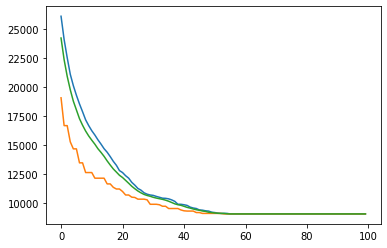

In [10]:
sga.plot_costs()

In [12]:
K = 2

sga = SGA(population_size=500, chromosome_length=n, crossover_func=PMX, objective_func=tsp_objective_function,
             distance_matrix=dists, mutation_func=iterative_mutation_function, replace_method='mu+lambda',
             number_of_offspring=500, crossover_probability=0.95, mutation_probability=0.25, 
             number_of_iterations=50)

sga.run(with_tqdm=True)

100%|██████████| 50/50 [17:12<00:00, 20.64s/it]


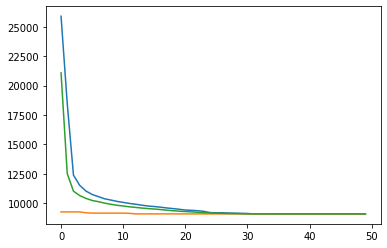

In [13]:
sga.plot_costs()